In [1]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.svm import SVC #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

from tqdm import tqdm

In [2]:
train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

In [3]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

In [6]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [7]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [8]:
data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], axis=1, inplace=True)
test_df.drop(['Fare'], axis=1, inplace=True)

In [9]:
data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'],axis=1, inplace=True)
test_df.drop(['Age'], axis=1, inplace=True)

In [10]:
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [11]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_test = test_df.copy()

In [12]:
std_scaler = StandardScaler()
X = pd.DataFrame(std_scaler.fit_transform(X))
X_test = pd.DataFrame(std_scaler.transform(X_test))

In [13]:
n_neighbors = [12,13,14]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(10,30,1))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
0.8786918484565543
KNeighborsClassifier(leaf_size=26, n_neighbors=13)


In [14]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)


In [15]:
#CV_Score = cross_val_score(gd, X, y, cv=5)
#print(CV_Score)
#CV_Score.mean()

In [16]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2, 
                           weights='uniform')
knn.fit(X, y)
y_pred = knn.predict(X_test)

In [17]:
knn.score(X,y)

0.8619528619528619

In [18]:
CV_Score = cross_val_score(knn, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.79888268 0.81460674 0.87078652 0.80898876 0.84831461]


0.8283158621555458

In [19]:
list_score = []
k=0.01
for i in (range(1)): # подбор оптимального С
    
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model = LogisticRegression(C=0.02, max_iter=1000).fit(X,y)
    y_pred = model.predict(X_test)
    list_score.append([model.score(X,y),k])
    k=k+0.01

list_score

[[0.8305274971941639, 0.01]]

In [20]:
CV_Score = cross_val_score(model, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.81564246 0.8258427  0.83707865 0.8258427  0.84269663]


0.8294206264515724

In [21]:
z=[]
k=1
for i in tqdm(range(1)):
    #model_tree = DecisionTreeClassifier(max_depth=16, ccp_alpha=0.002).fit(X_train,y_train)
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_tree = DecisionTreeClassifier(max_depth=4,ccp_alpha=0.01).fit(X,y)
    y_pred = model_tree.predict(X_test)
    z.append([model_tree.score(X,y),k])
    k = k + 1
z

100%|██████████| 1/1 [00:00<00:00, 166.54it/s]


[[0.8327721661054994, 1]]

In [22]:
CV_Score = cross_val_score(model_tree, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.84916201 0.83146067 0.84269663 0.81460674 0.8258427 ]


0.8327537505492435

In [23]:
cv=[]
k=0.5
for i in tqdm(range(1)):
   # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_clf = SVC(kernel='rbf', C=0.5).fit(X,y)
    y_pred = model_clf.predict(X_test)
    cv.append([model_clf.score(X,y),k])
    k = k + 0.05
cv

100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


[[0.8507295173961841, 0.5]]

In [24]:
CV_Score = cross_val_score(model_clf, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.8603352  0.84831461 0.84831461 0.81460674 0.85393258]


0.8451007469713139

In [25]:
k_xgb = []
k=1
for i in range(1):
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_xgb = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 5, n_estimators = 100, subsample = 0.1).fit(X,y)
    y_pred = model_xgb.predict(X_test)
    k_xgb.append([model_xgb.score(X,y),k])
    k = k + 1
k_xgb

[[0.8372615039281706, 1]]

In [26]:
CV_Score = cross_val_score(model_xgb, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.81564246 0.83146067 0.83146067 0.82022472 0.83146067]


0.8260498399347185

In [27]:
k_KNN = []
k=1
for i in range(1):
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_KNN = KNeighborsClassifier(algorithm = 'auto', weights = 'distance', leaf_size =1, 
               n_neighbors = 10).fit(X,y)
    y_pred_knn = model_KNN.predict(X_test)
    k_KNN.append([model_KNN.score(X,y),k])
    k = k + 1
k_KNN

[[0.8922558922558923, 1]]

In [28]:
CV_Score = cross_val_score(model_KNN, X, y, cv=5)
print(CV_Score)
CV_Score.mean()


[0.79888268 0.80337079 0.85393258 0.82022472 0.84831461]


0.8249450756386919

In [29]:
#[0.79888268 0.80337079 0.85393258 0.82022472 0.84831461]
#0.8249450756386919

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [31]:
cb = []
k=1
for i in tqdm(range(1)):
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_CatBoost = CatBoostClassifier(iterations=6,
    learning_rate=0.01, verbose = False).fit(X,y,plot=True)
    y_pred = model_CatBoost.predict(X_test)
    cb.append([model_CatBoost.score(X,y),k])
    k = k + 1
cb


  0%|          | 0/1 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


[[0.8338945005611672, 1]]

In [32]:
CV_Score = cross_val_score(model_CatBoost, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.7877095  0.8258427  0.84269663 0.8258427  0.8258427 ]


0.8215868432615656

In [33]:
#std_scaler = StandardScaler()
#X['r']= pd.DataFrame(std_scaler.fit_transform(pd.DataFrame(model_KNN.predict(X))))


In [34]:
#X


In [35]:
#X_test

In [36]:
#X_test['r'] = X['r'][:418]

In [37]:
X.head()

,0,1,2,3,4,5
0,0.827377,-0.737695,0.059160,-0.060661,-1.407144,-1.143781
1,-1.566107,1.355574,0.059160,-0.060661,1.429429,1.540439
2,0.827377,1.355574,-0.560975,-0.060661,-0.698001,-0.249041
3,-1.566107,1.355574,0.059160,-1.604923,1.429429,0.645699
4,0.827377,-0.737695,-0.560975,-0.060661,-0.698001,0.645699


In [38]:
Rtree = []
k=1
for i in tqdm(range(1)):
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model_random_tree = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=1).fit(X,y)
    y_pred = model_random_tree.predict(X_test)
    Rtree.append([model_random_tree.score(X,y),k])
    k = k + 1
Rtree



100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


[[0.8922558922558923, 1]]

In [39]:
CV_Score = cross_val_score(model_random_tree, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.80446927 0.79213483 0.86516854 0.83146067 0.85955056]


0.8305567760969179

In [40]:
import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

In [41]:
model_nr = kr.Sequential()
model_nr.add(kr.layers.Dense(units=21 , activation='relu'))
model_nr.add(kr.layers.Dense(units=1 , activation='sigmoid'))
model_nr.compile(loss='mse',optimizer='sgd',metrics=["accuracy"])#loss='mse',optimizer='sgd'
y_pred = model_nr.fit(x=X,y=y, epochs=500, validation_split=0.33)



2022-10-19 13:44:26.718838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-19 13:44:26.850882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
19/19 [==============================] - 1s 17ms/step - loss: 0.3332 - accuracy: 0.3020 - val_loss: 0.3441 - val_accuracy: 0.2475
Epoch 2/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3214 - accuracy: 0.3171 - val_loss: 0.3304 - val_accuracy: 0.2475
Epoch 3/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3102 - accuracy: 0.3289 - val_loss: 0.3173 - val_accuracy: 0.2475
Epoch 4/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2996 - accuracy: 0.3305 - val_loss: 0.3049 - val_accuracy: 0.2644
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.3389 - val_loss: 0.2934 - val_accuracy: 0.2814
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2803 - accuracy: 0.3523 - val_loss: 0.2828 - val_accuracy: 0.3051
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2718 - accuracy: 0.3943 - val_loss: 0.2729 - val_accuracy: 0.4203
Epoch 8/500


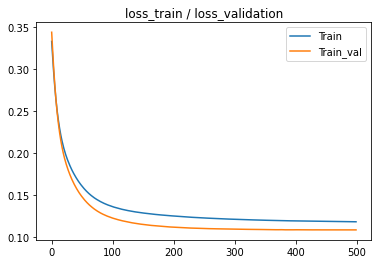

In [42]:
plt.title('loss_train / loss_validation')
plt.plot(y_pred.history['loss'], label='Train')
plt.plot(y_pred.history['val_loss'], label='Train_val')
plt.legend()

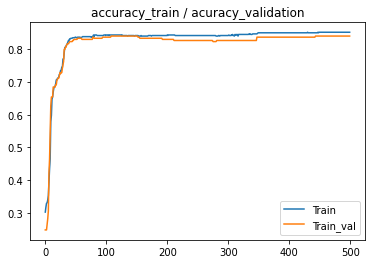

In [43]:
plt.title('accuracy_train / acuracy_validation')
plt.plot(y_pred.history['accuracy'], label='Train')
plt.plot(y_pred.history['val_accuracy'], label='Train_val')
plt.legend()

In [44]:
#mix = pd.DataFrame()
#mix['log_reg'] = model.predict(x_final)
#mix['tree'] = model_tree.predict(x_final)
#mix['cvm'] = model_clf.predict(x_final)
#mix['boost'] = model_xgb.predict(x_final)
                            #mix['gd'] = gd.predict(x_final)
#mix['rtree'] = model_random_tree.predict(X_test)
#mix['cat'] = model_CatBoost.predict(x_final)
#mix['nr'] = model_nr.predict(x_final)

In [45]:
#sur=[]
#for i in mix.values:
#    if i.mean() == 0.5:
#        sur.append(np.random.binomial(1,0.5))
#    else:
#        sur.append(np.round(i.mean(),0))

In [46]:
#mix['Survived'] = sur

In [47]:
#pd.options.display.max_rows = 100

In [48]:
test_data = pd.read_csv("../input/titanic/test.csv")

In [49]:
sub= pd.DataFrame(test_data["PassengerId"])
sub["Survived"] = np.round(model_KNN.predict(X_test),0)
sub["Survived"] = sub["Survived"].astype(int)
sub.to_csv('submission.csv', index=False)


In [50]:
#def boost(x, y):
 #   X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    #      log regress
 #   model = LogisticRegression().fit(X_train,y_train)
 #   model.predict(X_test)
    #   SVM -метод опорных векторов(неважно показавает себя(( 
    #model_2 = svm.LinearSVC().fit(X_train,y_train)
    #model_2.predict(X_test)
    
    # LightGBM + GridSearchCV
    #model_3 = lgb.LGBMClassifier()
    #params = {
    #"n_estimators": [3, 5, 10, 50, 100, 200], # total tree number
    #"learning_rate": [0.01, 0.05, 0.1, 0.3], # learning rate
    #"max_depth": [1, 3, 5, 10, 15], # max depth of each tree
    #"subsample": [0.6, 0.8, 1] # subsample rate of data
    #  }
    #model_rs = GridSearchCV(model_3, params, n_jobs=-1, cv=5)
    #model_rs.fit(X_train, y_train)
    #model_rs.predict(X_test)
    
    
 #   return model#,model_2.score(X_test,y_test), model_rs.score(X_test,y_test))

In [51]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
